# Python for Fantasy Football - Random Forest and XGBoost Hyperparameter Tuning
Welcome to part 10 of my Python for Fantasy Football series! Since part 5 we have been attempting to create our own expected goals model from the __[StatsBomb NWSL and FA WSL data](https://github.com/statsbomb/open-data)__ using machine learning. If you missed any of the previous articles or need a refresher, links are below:

__[Part 1](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction/)__
, __[Part 2](http://www.fantasyfutopia.com/python-for-fantasy-football-matchup-adjustment/)__, __[Part 3](http://www.fantasyfutopia.com/python-for-fantasy-football-getting-and-cleaning-data/)__, __[Part 4](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction-to-machine-learning/)__, __[Part 5](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction/)__, __[Part 6](http://www.fantasyfutopia.com/python-for-fantasy-football-addressing-class-imbalance-in-machine-learning/)__, __[Part 7](http://www.fantasyfutopia.com/python-for-fantasy-football-addressing-class-imbalance-part-2/)__, __[Part 8](http://www.fantasyfutopia.com/python-for-fantasy-football-understanding-random-forests/)__, __[Part 9](http://www.fantasyfutopia.com/python-for-fantasy-football-feature-engineering-for-machine-learning/)__

In this article we will be looking at the final piece of the puzzle, hyperparameter tuning. As mentioned in __[part 8](http://www.fantasyfutopia.com/python-for-fantasy-football-understanding-random-forests/)__, machine learning algorithms like random forests and XGBoost have settings called 'hyperparameters' that can be adjusted to help improve the model. I briefly explained the most important settings for sklearn's random forest classifier in __[part 8](http://www.fantasyfutopia.com/python-for-fantasy-football-understanding-random-forests/)__, so it might be worth going back and reminding yourself of those now if you need to. We'll be looking at how to go about tuning random forest hyperparameters here, and we'll also investigate the XGBoost classifier too, which has some different hyperparameters. At the end of the article we'll use the best model on an updated dataset to allow us to create some xG plots for NWSL/FA WSL teams and players.

In [1]:
# Reloads modules automatically in case there are any changes
# See https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%reload_ext autoreload
%autoreload 2

# Show matplotlib plots without having to call .show()
%matplotlib inline

In [2]:
# Import everything
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from collections import OrderedDict
from imblearn.under_sampling import TomekLinks

## Create a held-out test set
We want to know how well our model performs on unseen data, so it's good practice to hold back some of our data in a test set that isn't used at all for model training. You could skip this step in this particular case, but in most real-world problems you will need your model to generalise well, so it's worth running through the process here:

- Use train/test split to create a test set. Setting stratify=y ensures that the class distribution of the test set represents the training data well. Note that this can often be smaller than 20% of the original dataset, but we want to ensure we have enough examples of goals in our training set here.
- Split the data again into a training set and a validation set, then train the model and check the results using the validation set. Alternatively, you can use cross-validation to train the model, which we will be doing in this case. We will use stratified k-fold cross-validation to ensure that the validation sets are of a similar class distribution to the held-out test set.
- Tune model hyperparameters to find the settings that achieve the best results on the validation set.
- Evaluate the best model on the held-out test set. This will ensure that we aren't overfitting, as well as give us an idea of how well the model will perform on unseen data in the future.

If that's confusing, hopefully it will become clearer in the next section!

In [3]:
# Load data
data = pd.read_csv('data.csv', index_col=0)
X = data.drop('goal', axis=1)
y = data['goal']

# Create a held-out set to properly test our final model
# We will use cross-validation on the training set to tune parameters, then test on unseen data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, stratify=y, random_state=42)

## Visualising different hyperparameters
In this section, we're going to generate some plots to visualise how changing the hyperparameters can affect model results. This isn't necessary in practice when training your own models, as we'll see later, but it's useful to know about as it does give a good idea of how to narrow down your options.

First, let's define a function to create 'n_estimators' (number of trees in the random forest) vs 'Brier loss' plots.

In [4]:
# Define a function to create n_estimators vs Brier loss plots for different hyperparameters
# Modified from https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
def plot_loss(model_list, min_estimators=10, max_estimators=200):
    # Map a classifier name to a list of (n_estimators, Brier loss) pairs
    loss_rate = OrderedDict((clf_name, []) for clf_name, _ in model_list)

    # Range of 'n_estimators' values to explore
    min_estimators = min_estimators
    max_estimators = max_estimators

    for clf_name, clf in model_list:
        for i in range(min_estimators, max_estimators + 1):
            clf.set_params(n_estimators=i)
            clf.fit(X_train, y_train)

            # Record the Brier loss for each 'n_estimators=i' setting
            y_pred = clf.predict(X_test)
            y_pred_proba = clf.predict_proba(X_test)
            brier = brier_score_loss(y_test, y_pred_proba[:,1])
            loss_rate[clf_name].append((i, brier))
    
    # Generate the plot
    plt.figure(figsize=(12,8))
    
    for clf_name, clf_err in loss_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=clf_name)

    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("Brier loss")
    plt.legend(loc="upper right");
    return

### max_features
We can pass a list of models to this function to plot the results for different hyperparameter settings. For instance, let's try changing 'max_features' and see how this would affect our loss score.

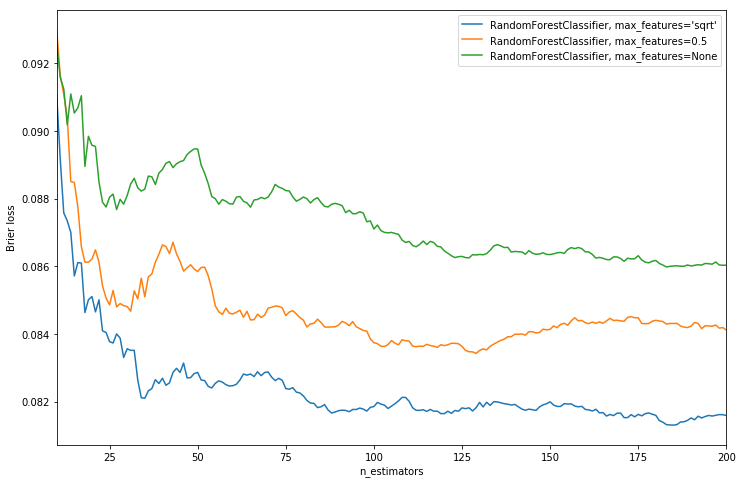

In [5]:
# Setting warm_start=True is necessary for tracking the loss rate during training for different values of n_estimators
max_features = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_features='sqrt', random_state=42)),
    ("RandomForestClassifier, max_features=0.5",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_features=0.5, random_state=42)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_features=None, random_state=42)),
]

# Note that 'log2' is another commonly used value of max_features, but in this case it's essentially the same as 'sqrt'
plot_loss(max_features)

By default the algorithm will use max_features='sqrt', which means that each tree in the random forest will only be trained using sqrt(13), or about 28%, of the 13 total input features. We know from __[part 9](http://www.fantasyfutopia.com/python-for-fantasy-football-feature-engineering-for-machine-learning/)__ that all of our model features help performance, so removing some of them will make each individual tree weaker. However, the advantage of doing this is that you will get a lot more variation in the types of trees being created, so they will all generate slightly different predictions. When you combine the predictions from multiple weak trees together you will get a more robust overall model, as indicated by the reduction in Brier loss when n_estimators is increased. We could consider trying different values either side of max_features=0.28 (e.g. 0.2, 0.35 etc), but to make things simpler in this case I'll stick with the default value of 'sqrt'.

It's also worth noting that whilst increasing n_estimators does tend to reduce the loss score, after about 100 trees the improvements appear to be marginal. More trees means more computations, so it's always worth considering the trade-off between training time and model score.

### min_samples_leaf
Let's create another plot, this time looking at different values of min_samples_leaf.

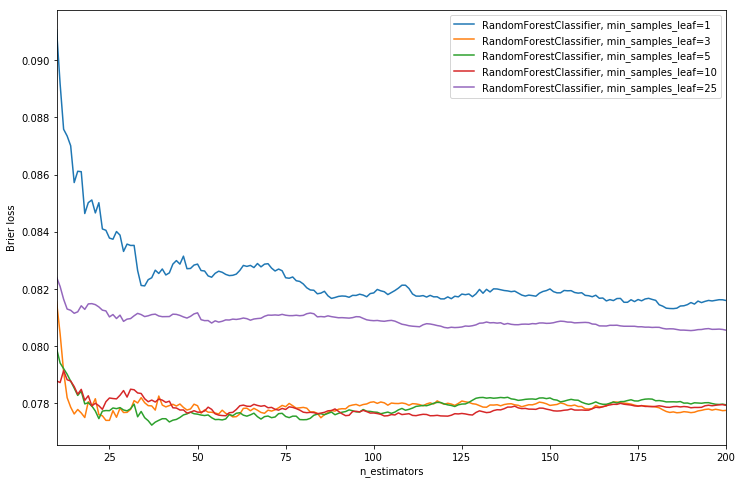

In [6]:
min_leaf = [
    ("RandomForestClassifier, min_samples_leaf=1",
        RandomForestClassifier(n_estimators=100, warm_start=True, min_samples_leaf=1, random_state=42)),
    ("RandomForestClassifier, min_samples_leaf=3",
        RandomForestClassifier(n_estimators=100, warm_start=True, min_samples_leaf=3, random_state=42)),
    ("RandomForestClassifier, min_samples_leaf=5",
        RandomForestClassifier(n_estimators=100, warm_start=True, min_samples_leaf=5, random_state=42)),
    ("RandomForestClassifier, min_samples_leaf=10",
        RandomForestClassifier(n_estimators=100, warm_start=True, min_samples_leaf=10, random_state=42)),
    ("RandomForestClassifier, min_samples_leaf=25",
        RandomForestClassifier(n_estimators=100, warm_start=True, min_samples_leaf=25, random_state=42)),
]

plot_loss(min_leaf)

The default value of 1 looks to be significantly worse than the other values we tested, so we definitely want to adjust this later to increase model performance. It looks like there is a sweet spot somewhere between 3-10, so we should focus our attention there. 

As __[this excellent article](https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d)__ points out, we want to make sure that we avoid under or overfitting when adjusting hyperparameters. If we aren't careful we will end up with an algorithm that doesn't generalise well to the unseen test set. To illustrate this, let's look at another plot using code from __[the article](https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d)__.

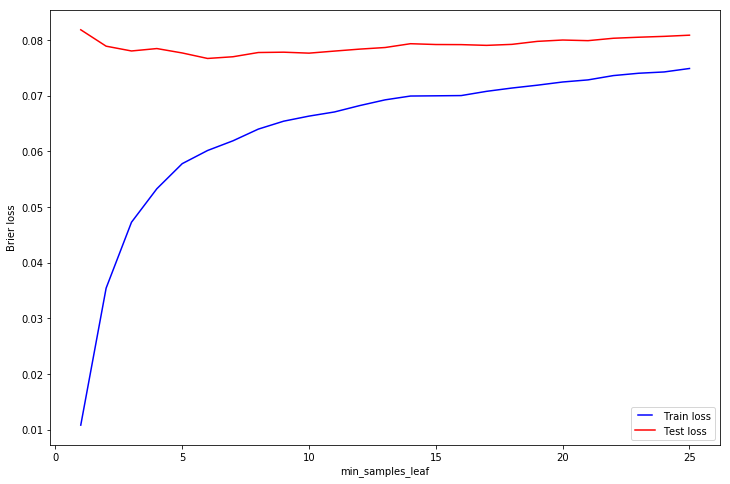

In [7]:
# https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d
min_leaf = [int(x) for x in np.linspace(start=1, stop=25, num=25)]
train_results = []
test_results = []
for leaf in min_leaf:
    rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=leaf, n_jobs=-1, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_prob_train = rf.predict_proba(X_train)[:,1]
    train_score = brier_score_loss(y_train, y_pred_prob_train)
    train_results.append(train_score)
    y_pred_prob_test = rf.predict_proba(X_test)[:,1]
    test_score = brier_score_loss(y_test, y_pred_prob_test)
    test_results.append(test_score)
plt.figure(figsize=(12, 8))
line1, = plt.plot(min_leaf, train_results, 'b', label='Train loss')
line2, = plt.plot(min_leaf, test_results, 'r', label='Test loss')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Brier loss')
plt.xlabel('min_samples_leaf');

We can see that decreasing min_samples_leaf improves the Brier loss score, but there is a problem - the loss score on the unseen test set actually gets worse once min_samples_leaf drops below about 3-5. If we set min_samples_leaf too low, the model will start to overfit the training set and won't generalise as well to unseen data.

### max_depth
Let's repeat the process for max_depth. We know from __[part 8](http://www.fantasyfutopia.com/python-for-fantasy-football-understanding-random-forests/)__ that limiting tree depth can help to prevent overfitting and avoids overly complex trees.

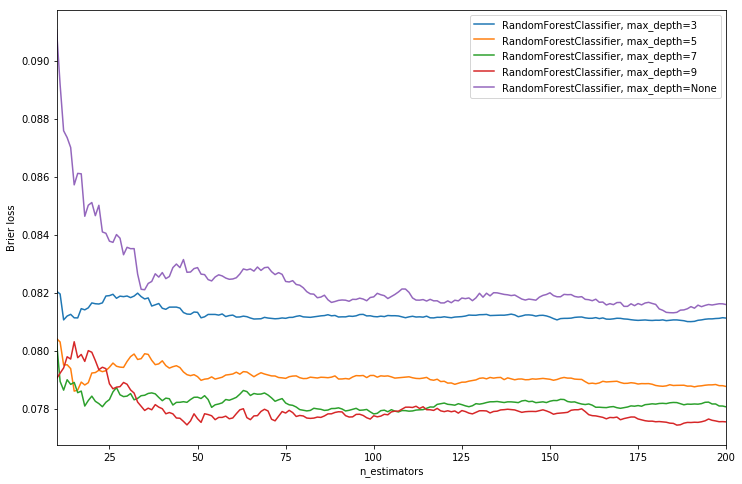

In [8]:
max_depth = [
    ("RandomForestClassifier, max_depth=3",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_depth=3, random_state=42)),
    ("RandomForestClassifier, max_depth=5",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_depth=5, random_state=42)),
    ("RandomForestClassifier, max_depth=7",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_depth=7, random_state=42)),
    ("RandomForestClassifier, max_depth=9",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_depth=9, random_state=42)),
    ("RandomForestClassifier, max_depth=None",
        RandomForestClassifier(n_estimators=100, warm_start=True, max_depth=None, random_state=42)),
]

plot_loss(max_depth)

Once again we can see that the default value of max_depth=None is quite a bit worse than values of 7 or 9. We should therefore try setting max_depth to different values either side of 9, which should hopefully improve our model score. Let's check the train/test loss plot for max_depth as well to check for overfitting potential.

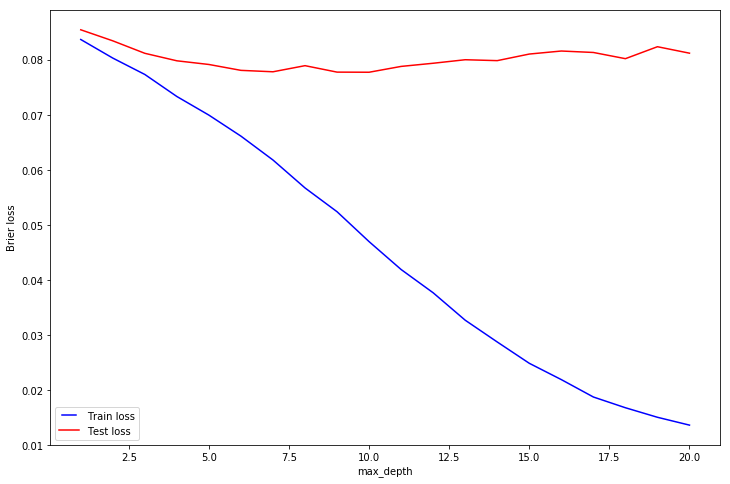

In [9]:
max_depths = np.linspace(1, 20, 20, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(n_estimators=100, max_depth=max_depth, n_jobs=-1, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_prob_train = rf.predict_proba(X_train)[:,1]
    train_score = brier_score_loss(y_train, y_pred_prob_train)
    train_results.append(train_score)
    y_pred_prob_test = rf.predict_proba(X_test)[:,1]
    test_score = brier_score_loss(y_test, y_pred_prob_test)
    test_results.append(test_score)
plt.figure(figsize=(12, 8))
line1, = plt.plot(max_depths, train_results, 'b', label='Train loss')
line2, = plt.plot(max_depths, test_results, 'r', label='Test loss')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Brier loss')
plt.xlabel('max_depth');

We can clearly see that increasing max_depth decreases the Brier loss score on the training set. However, the fact that train_loss starts to flatten out and then increase again after values of about 10-11 shows us that we will overfit if we set max_depth too high. Values between 6-11 look to be our best bet here.

## Tuning random forest hyperparameters using grid search
Whilst the above plots are useful to help us understand what happens when we adjust hyperparameters, you don't actually need to create them to understand what values you should be using. Sklearn has a function called 'GridSearchCV' built-in, which allows us to test out different hyperparameters and find the optimal combination. The way it works is as follows:

- Specify a base model and cross-validation approach to use.
- Pass a parameter grid to the function, with different values that you want to test out.
- The function will try every single combination of each parameter in turn and find the model score.

This approach can obviously be quite slow if you have lots of different hyperparameters you want to test (more on that in a bit), which is why it was helpful to narrow down the range of values we wanted to try. That said, the results will give us the absolute best model to use, which can improve our loss score quite significantly. So let's try it out!

First, let's fit a base model to use as a comparison. Note that the loss score of 0.07830 here is a bit different to the one we were able to achieve in __[part 9](http://www.fantasyfutopia.com/python-for-fantasy-football-feature-engineering-for-machine-learning/)__, as this time we used train/test split to create a held-out test set.

In [10]:
# Fit base model to use for comparison
m = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_features='sqrt', random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(m, X_train, y_train, cv=cv, scoring='brier_score_loss')
print('Brier loss:', "{0:.5f}".format(np.mean(scores)*-1))

Brier loss: 0.07830


Next, let's run a grid search and see what happens. I chose to print the results for every single combination here to show you how it works, but in practice you probably won't want to do this if you have lots of different values!

In [11]:
# Create the parameter grid
params = {
    'min_samples_leaf': [3, 4, 5, 6, 7],
    'max_depth': [7, 8, 9, 10, 11]
}

# Create the grid search model
gs = GridSearchCV(estimator=m, param_grid=params, cv=cv, n_jobs=-1,
                  scoring='brier_score_loss', return_train_score=True)

# Fit gs
gs.fit(X_train, y_train)

# Define function to print the results of the grid search
def print_gs_results(gs, print_all=True):
    if print_all == True:
        print('Grid scores:')
        means = gs.cv_results_['mean_test_score']*-1
        stds = gs.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, gs.cv_results_['params']):
            print("%0.5f (+/-%0.05f) for %r"
                  % (mean, std * 2, params))
        print()
        print('Best:', "{0:.5f}".format(gs.best_score_*-1),'using %s' % gs.best_params_)
    else:
        print('Best:', "{0:.5f}".format(gs.best_score_*-1),'using %s' % gs.best_params_)
    return

print_gs_results(gs=gs)

Grid scores:
0.07532 (+/-0.00539) for {'max_depth': 7, 'min_samples_leaf': 3}
0.07540 (+/-0.00470) for {'max_depth': 7, 'min_samples_leaf': 4}
0.07569 (+/-0.00444) for {'max_depth': 7, 'min_samples_leaf': 5}
0.07593 (+/-0.00436) for {'max_depth': 7, 'min_samples_leaf': 6}
0.07600 (+/-0.00408) for {'max_depth': 7, 'min_samples_leaf': 7}
0.07512 (+/-0.00538) for {'max_depth': 8, 'min_samples_leaf': 3}
0.07499 (+/-0.00480) for {'max_depth': 8, 'min_samples_leaf': 4}
0.07527 (+/-0.00423) for {'max_depth': 8, 'min_samples_leaf': 5}
0.07557 (+/-0.00353) for {'max_depth': 8, 'min_samples_leaf': 6}
0.07565 (+/-0.00399) for {'max_depth': 8, 'min_samples_leaf': 7}
0.07503 (+/-0.00542) for {'max_depth': 9, 'min_samples_leaf': 3}
0.07498 (+/-0.00541) for {'max_depth': 9, 'min_samples_leaf': 4}
0.07559 (+/-0.00439) for {'max_depth': 9, 'min_samples_leaf': 5}
0.07545 (+/-0.00428) for {'max_depth': 9, 'min_samples_leaf': 6}
0.07569 (+/-0.00445) for {'max_depth': 9, 'min_samples_leaf': 7}
0.07456 (+/-

We can see here that after trying out each combination, the grid search has determined that the optimal values to use are max_depth=10 and min_samples_leaf=3, which has improved our loss score significantly.

<img src="https://media.giphy.com/media/mXuPwEBHCtaH2ndoBy/giphy.gif" />

## Tuning XGBoost hyperparameters
In __[part 7](http://www.fantasyfutopia.com/python-for-fantasy-football-addressing-class-imbalance-part-2/)__ we saw that the XGBoost algorithm was able to achieve similar results to sklearn's random forest classifier, but since the model results typically improve quite a bit with hyperparameter tuning it's well worth investigating that further here. I briefly mentioned the concept of '__[gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting)__' in __[part 8](http://www.fantasyfutopia.com/python-for-fantasy-football-understanding-random-forests/)__, so I won't cover it in-depth here, but if you want to learn more the __[XGBoost documentation](https://xgboost.readthedocs.io/en/latest/index.html)__ is a good place to start. Let's fit a model using the default parameters to use as a baseline.

In [12]:
# Try XGBoost
# binary:logistic is an objective function for binary classification that outputs probability estimates - ideal for us
# See https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters
xgb = XGBClassifier(objective='binary:logistic', random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)
scores = cross_val_score(xgb, X_train, y_train, cv=cv, scoring='brier_score_loss')
print('Brier loss:', "{0:.5f}".format(np.mean(scores)*-1))

Brier loss: 0.07552


The default XGBoost model achieves a Brier loss score of 0.07552, which is quite a bit better than our baseline random forest model, but not as good as the tuned random forest we just created.  To check the default hyperparameters, we can simply print them:

In [13]:
print(xgb.get_params())

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}


Note that I am using the sklearn wrapper for XGBoost, which changes some of the hyperparameter names to make them more consistent with sklearn's naming convention, so you will already recognise things like 'n_estimators', 'max_depth' etc. We'll be tuning a few hyperparameters that we haven't come across yet, which are briefly discussed below:

- learning_rate = function to shrink weights of the tree predictions at each learning step. The way XGBoost works is it starts with an initial estimate, which is updated using the predictions from new trees. The learning rate is essentially there to help prevent overfitting by controlling the amount that the initial estimate is updated. The new predictions are weighted by the learning rate, so a high learning rate means that the initial estimate will be updated more drastically, and vice versa. If we set the learning rate too high our model won't generalise well, but values that are too low will mean that our model will take far too long to fit. If you are going to try out lower learning rates and don't mind a long wait, it's a good idea to add more trees to the model by tuning n_estimators, so even with a low learning rate the algorithm is still able to model a large number of different situations.
- subsample = the fraction of the dataset to use for each tree. We already know that it's a good idea to introduce some variation into each tree in our ensemble, as the overall predictions become more robust. One way to do this is by restricting the amount of data the model can use.
- colsample_bytree = the fraction of columns to use for each tree. This is similar to max_features in the random forest classifier, and is another way of adding more variety to each tree in the ensemble.
- min_child_weight =  from the docs: *"minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning."* This is essentially a way to control overfitting by using the number of samples at the leaf node of a tree, which is similar to 'min_samples_leaf' in a random forest model.

If you need a different/more detailed explanation of these hyperparameters, I suggest looking at __[this excellent article](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)__, as well as the __[XGBoost documentation](https://xgboost.readthedocs.io/en/latest/parameter.html#)__. For now, let's go ahead and try a grid search to see if we can reach a good combination of hyperparameters. In this case we'll use a randomised grid search, which randomly tries a fixed number (n_iter) of different hyperparameter combinations instead of testing every single one. Whilst this isn't necessarily as accurate as an exhaustive grid search, it's much faster to implement when you want to try out lots of different settings!

In [14]:
# Create the parameter grid
params = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=500, num=9)],
    'max_depth': [i for i in range(3, 10)],
    'min_child_weight': [i for i in range(1, 7)],
    'subsample': [i/10.0 for i in range(6,11)],
    'colsample_bytree': [i/10.0 for i in range(6,11)]
}

# Create the randomised grid search model
# See http://scikit-learn.sourceforge.net/stable/modules/generated/sklearn.grid_search.RandomizedSearchCV.html
# "n_iter = number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution"
rgs = RandomizedSearchCV(estimator=xgb, param_distributions=params, n_iter=20, cv=cv, random_state=42, n_jobs=-1,
                         scoring='brier_score_loss', return_train_score=True)

# Fit rgs
rgs.fit(X_train, y_train)

# Print results
print_gs_results(gs=rgs, print_all=False)

Best: 0.07524 using {'subsample': 0.9, 'n_estimators': 500, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.9}


The model didn't really improve that much relative to the baseline, which is a bit disappointing. It's well worth testing out different values for the hyperparameters, as well as n_iter, to see if you can do better! If you have more time, you could tune each hyperparameter one-by-one using an exhaustive grid search to ensure you get the optimal values.

## Evaluating the best models on the held-out test set
After running a grid search, you can access the model with the optimal combination of hyperparameters by using '.best_estimator_'. Let's see how the best random forest and best XGBoost models perform on unseen data - the test set we put aside earlier.

In [15]:
# Define a function to help fit models and print the results
def print_results(rf, xgb, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    # Fit model
    rf.fit(X_train, y_train)
    xgb.fit(X_train, y_train)
    
    # Get predicted probabilities
    y_pred_proba_rf = rf.predict_proba(X_test)[:,1]
    y_pred_proba_xgb = xgb.predict_proba(X_test)[:,1]

    # Print results
    print('Actual goals:', sum(y_test))
    print('Predicted goals (rf):', '{0:.2f}'.format(sum(y_pred_proba_rf)))
    print('Predicted goals (xgb):', '{0:.2f}'.format(sum(y_pred_proba_xgb)))
    print('Brier loss (rf):', '{0:.5f}'.format(brier_score_loss(y_test, y_pred_proba_rf)))
    print('Brier loss (xgb):', '{0:.5f}'.format(brier_score_loss(y_test, y_pred_proba_xgb)))
    return

# Evaluate best models on the hold-out set
best_rf = gs.best_estimator_
best_xgb = rgs.best_estimator_

print_results(rf=best_rf, xgb=best_xgb)

Actual goals: 61
Predicted goals (rf): 61.16
Predicted goals (xgb): 62.51
Brier loss (rf): 0.07696
Brier loss (xgb): 0.07797


We can see that our loss score has got worse for both models, with the random forest outperforming XGBoost in this case. The predicted goals totals (aka expected goals) do appear to match up quite well with the actual goals total here though, which is what we were hoping to see.

We saw in __[part 7](http://www.fantasyfutopia.com/python-for-fantasy-football-addressing-class-imbalance-part-2/)__ that Tomek's links re-sampling and calibrating probabilities might help our models, so let's try those now to check.

In [16]:
# Try calibrating the probabilities
calibrated_rf = CalibratedClassifierCV(gs.best_estimator_, cv=cv, method='sigmoid')
calibrated_xgb = CalibratedClassifierCV(rgs.best_estimator_, cv=cv, method='sigmoid')

print_results(rf=calibrated_rf, xgb=calibrated_xgb)

Actual goals: 61
Predicted goals (rf): 61.93
Predicted goals (xgb): 60.93
Brier loss (rf): 0.07982
Brier loss (xgb): 0.07995


In [17]:
# Try Tomek links resampling
tomek = TomekLinks(n_jobs=-1, random_state=42)
X_train_res, y_train_res = tomek.fit_resample(X_train, y_train)

print('UNCALIBRATED')
print_results(rf=best_rf, xgb=best_xgb, X_train=X_train_res, y_train=y_train_res, X_test=X_test.values)
print('\nCALIBRATED')
print_results(rf=calibrated_rf, xgb=calibrated_xgb, X_train=X_train_res, y_train=y_train_res, X_test=X_test.values)

UNCALIBRATED
Actual goals: 61
Predicted goals (rf): 66.82
Predicted goals (xgb): 67.34
Brier loss (rf): 0.07900
Brier loss (xgb): 0.07775

CALIBRATED
Actual goals: 61
Predicted goals (rf): 67.55
Predicted goals (xgb): 65.52
Brier loss (rf): 0.08032
Brier loss (xgb): 0.07953


We can see that in general the loss scores got worse. Tomek's links re-sampling did improve our XGBoost model a little bit, but still not enough to achieve a better loss score than the random forest model with no re-sampling. You could fine-tune the models more by trying out different hyperparameter combinations on the held-out test set, as mentioned earlier, but in the interest of time I'll be sticking with the random forest model that achieved a Brier loss of 0.07696 on the held-out test set.

## Saving and loading machine learning models
Now we have trained our final model, it's a good idea to save it so we can use it again whenever we like, for example to calculate xG values on future matches. The 'pickle' module provides an easy way to do this:

In [18]:
# Save the best model to disk so you can use it again whenever you like (e.g. in another notebook etc)
import pickle
filename = 'final_model.sav'
pickle.dump(best_rf, open(filename, 'wb'))
 
# This is how you would load the model again
model = pickle.load(open(filename, 'rb'))

## Making use of machine learning model predictions
There wouldn't be much point in doing machine learning if we couldn't gain some useful insights from the predictions made by our model. In this case the point of our model is to calculate 'expected goals', so let's do that now and plot some examples! I modified the data preprocessing script from __[part 9](http://www.fantasyfutopia.com/python-for-fantasy-football-feature-engineering-for-machine-learning/)__ slightly to generate a more up-to-date version of the data than I used for model training. Both the data and preprocessing script are available on __[GitHub](https://github.com/twhelan22)__. For penalties, I have assumed xG = average conversion rate, which is typically around 0.75.

In [19]:
# Use the model to make predictions on an updated version of the dataset
non_pen = pd.read_csv('non_pen.csv', index_col=0)
pens = pd.read_csv('pens.csv', index_col=0)

X_new = non_pen.drop('goal', axis=1)
y_new = non_pen['goal']

# Note that this df contains some extra info, so we need to remove those columns before fitting the model
extra_cols = ['player_name', 'team_name', 'match_id', 'x_loc', 'y_loc', 'pass_player_name']
extras = X_new[extra_cols]
X_new= X_new.drop(extra_cols, axis=1)

model.fit(X_new, y_new)

# Add xG and xA values using predict_proba
xg_df = X_new.copy()
xg_df['goal'] = y_new
xg_df['xg'] = model.predict_proba(X_new)[:,1]
xg_df['xa'] = np.where(xg_df['xg'].isna(), 0, xg_df['xg'])
xg_df = xg_df.merge(extras, left_index=True, right_index=True)
xg_df = xg_df.append(pens, sort=True)

# Convert x_loc and y_loc to metres to suit plotting functions later
# Pitch size is approx 104x68m, whereas StatsBomb use a coordinate system of 120x80 units
# You don't need to do this, but knowing how might be useful if your dataset uses a different coordinate system (e.g. Opta)
xg_df['x_loc_m'] = xg_df['x_loc'] / 120 * 104
xg_df['y_loc_m'] = xg_df['y_loc'] / 80 * 68

Now that's done, let's make some xG plots! In __[part 5](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction-to-machine-learning/)__ I singled out __[Peter McKeever's](https://twitter.com/petermckeever)__ article on expected goals, so I thought I'd mention his work here in a more positive light, as he has written some great articles about __[plotting football data in Python](http://petermckeever.com/plotting-xy-football-data-in-python/)__. I 'll be using a modified version of his code here and in the interest of time I won't go into full detail, so I strongly recommend checking out __[his articles](http://petermckeever.com/blog/)__ if you want to learn more.

In [20]:
# Define a function to draw a pitch
# See http://petermckeever.com/plotting-xy-football-data-in-python/
# Note that I added support for a 'final third' view also
# There is another good article on plotting with statsbomb data below if you want a slightly different approach
# https://towardsdatascience.com/advanced-sports-visualization-with-pandas-matplotlib-and-seaborn-9c16df80a81b
def draw_pitch(pitch, line, orientation, view):
    
    orientation = orientation
    view = view
    line = line
    pitch = pitch
    
    if orientation.lower().startswith("h"):
        
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.xlim(49,105)
            plt.ylim(-1,69)
        elif view.lower().startswith("t"):
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.xlim(69,105)
            plt.ylim(-1,69)
            # final third line
            lxt = [0,68] 
            lyt = [69,69]
            plt.plot(lxt,lyt,color=line,linestyle='--',zorder=5)
        else:
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.xlim(-1,105)
            plt.ylim(-1,69)
        ax.axis('off') # this hides the x and y ticks
    
        # side and goal lines #
        ly1 = [0,0,68,68,0]
        lx1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        ly2 = [13.84,13.84,54.16,54.16] 
        lx2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        ly3 = [13.84,13.84,54.16,54.16] 
        lx3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        ly4 = [30.34,30.34,37.66,37.66]
        lx4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        ly5 = [30.34,30.34,37.66,37.66]
        lx5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        ly6 = [24.84,24.84,43.16,43.16]
        lx6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        ly7 = [24.84,24.84,43.16,43.16]
        lx7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        ly8 = [0,68] 
        lx8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(93,34,color=line,zorder=5)
        plt.scatter(11,34,color=line,zorder=5)
        plt.scatter(52,34,color=line,zorder=5)

        circle1 = plt.Circle((93.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((10.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((52, 34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)

        ## Rectangles in boxes
        rec1 = plt.Rectangle((87.5,20), 16,30,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((0, 20), 16.5,30,ls='-',color=pitch, zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 106,70,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        
    else:
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.ylim(49,105)
            plt.xlim(-1,69)
        elif view.lower().startswith("t"):
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.ylim(69,105)
            plt.xlim(-1,69)
            # final third line
            lxt = [0,68] 
            lyt = [69,69]
            plt.plot(lxt,lyt,color=line,linestyle='--',zorder=5)
        else:
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.ylim(-1,105)
            plt.xlim(-1,69)
        ax.axis('off') # this hides the x and y ticks

        # side and goal lines #
        lx1 = [0,0,68,68,0]
        ly1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        lx2 = [13.84,13.84,54.16,54.16] 
        ly2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        lx3 = [13.84,13.84,54.16,54.16] 
        ly3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        lx4 = [30.34,30.34,37.66,37.66]
        ly4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        lx5 = [30.34,30.34,37.66,37.66]
        ly5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        lx6 = [24.84,24.84,43.16,43.16]
        ly6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        lx7 = [24.84,24.84,43.16,43.16]
        ly7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        lx8 = [0,68] 
        ly8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(34,93,color=line,zorder=5)
        plt.scatter(34,11,color=line,zorder=5)
        plt.scatter(34,52,color=line,zorder=5)

        circle1 = plt.Circle((34,93.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((34,10.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((34,52), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)


        ## Rectangles in boxes
        rec1 = plt.Rectangle((20, 87.5), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((20, 0), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 70,106,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        return

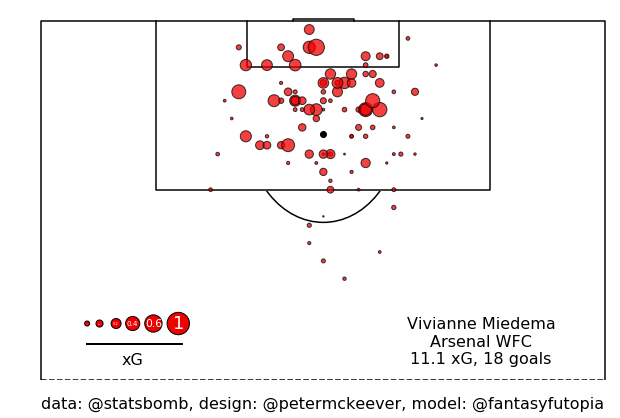

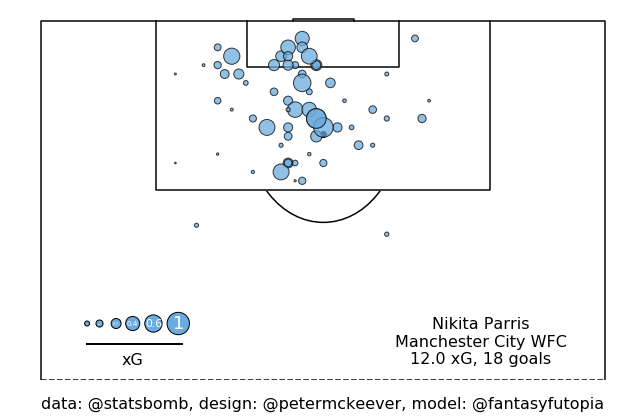

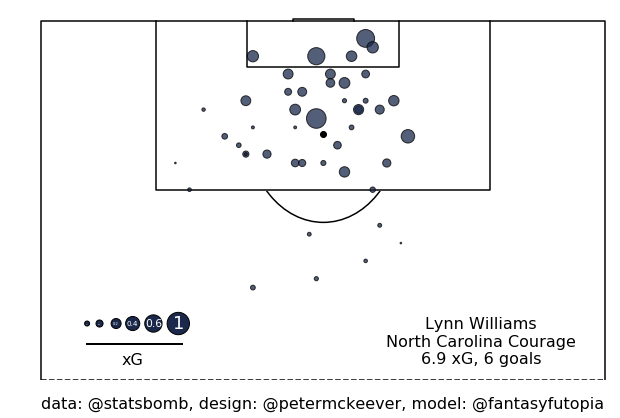

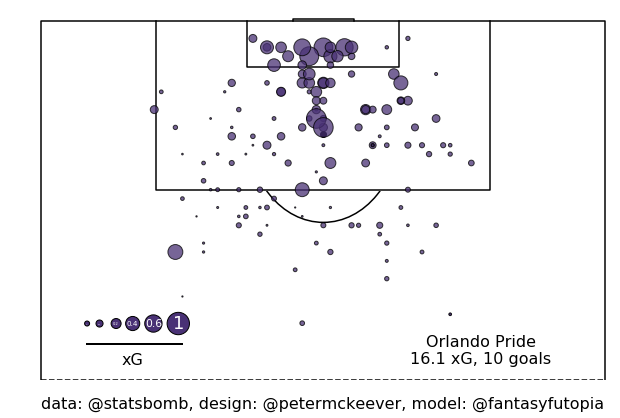

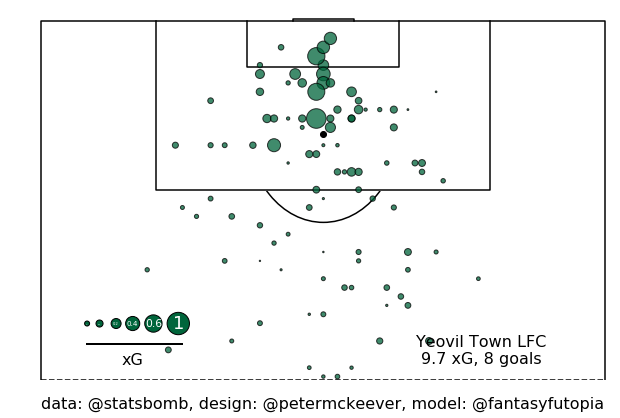

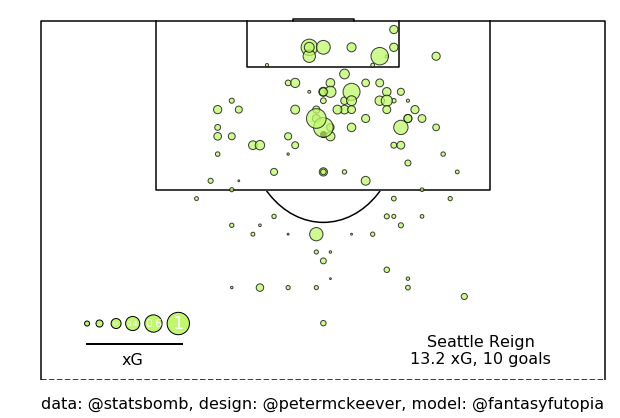

In [21]:
# Define a function to make xG plots for teams and players
def xg_plot(df, team_name, player_name=None, pitch_colour='#ffffff', line_colour='#000000', marker_colour='default'):
    
    # Draw pitch first
    draw_pitch(pitch_colour, line_colour, orientation='vertical', view='third')

    # Filter df 
    if player_name is not None:
        df = df[df['player_name'] == player_name]
        df = df[df['team_name'] == team_name]
    else:
        player_name=''
        df = df[df['team_name'] == team_name]
        
    # Assign marker colours for each team  
    markers = {'West Ham United LFC': '#7D2B3A', 'Reading WFC': '#004494', 'North Carolina Courage': '#1A284B',
               'Arsenal WFC': '#F00000', 'Chelsea LFC': '#001489', 'Bristol City WFC': '#DB0008',
               'Brighton & Hove Albion WFC': '#0054A6', 'Manchester City WFC': '#6CABDD', 'Washington Spirit': '#B02534',
               'Portland Thorns': '#561416', 'Utah Royals': '#022B52', 'Sky Blue FC': '#0C1963',
               'Birmingham City WFC': '#11437E', 'Liverpool WFC': '#E31B23', 'Chicago Red Stars': '#41B6E6',
               'Everton LFC': '#00369C', 'Orlando Pride': '#493175', 'Seattle Reign': '#C0F76D',
               'Houston Dash': '#E03F28', 'Yeovil Town LFC': '#00653B'}
    
    if marker_colour == 'default':
        marker_colour = markers.get(team_name)
    else: pass

    # Get x_loc, y_loc and xG
    x_loc = df['x_loc_m']
    y_loc = [68 - i for i in df['y_loc_m']] # Note y axis is flipped for vertical pitch view
    xg = [500 * i for i in df['xg']] # Scale xG values for plotting
    
    zo = 12 # This is to ensure everything is plotted above the pitch elements
    
    # Plot shots
    plt.scatter(y_loc, x_loc, s=xg, c=marker_colour, edgecolors='k', zorder=zo, alpha=0.75)

    # Add legend to explain that marker size = xG
    mSize = [0.05,0.10,0.2,0.4,0.6,1] 
    mSizeS = [500 * i for i in mSize]
    mx = [5.5,7,9,11,13.5,16.5]
    my = [74.5,74.5,74.5,74.5,74.5,74.5]
    plt.scatter(mx, my, s=mSizeS, facecolors=marker_colour, edgecolor='k', zorder=zo)
    plt.plot([5.5,17], [72.5,72.5], color=line_colour, lw=2, zorder=zo)
    i = 0
    for i in range(len(mx)):
        plt.text(mx[i], my[i], mSize[i], fontsize=mSize[i]*18, color=pitch_colour, zorder=zo, ha='center', va='center')
    plt.text(11, 71,'xG', color=line_colour, ha='center', va='center', zorder=zo, fontsize=16)

    # Add legend to show team/player info
    xg_sum = str(round(np.sum(df['xg']), 1))
    goal_sum = str(np.sum(df['goal']))
    legend_string = player_name + '\n' + team_name + '\n' + xg_sum + ' xG, ' + goal_sum + ' goals'
    plt.text(53, 72.75, legend_string, color=line_colour, ha='center', va='center', zorder=zo, fontsize=16)
    
    # Show Twitter info below
    info_string = 'data: @statsbomb, design: @petermckeever, model: @fantasyfutopia'
    plt.text(0, 66, info_string, color=line_colour, ha='left', va='bottom', zorder=zo, fontsize=16);
    return

xg_plot(df=xg_df, team_name='Arsenal WFC', player_name='Vivianne Miedema')
xg_plot(df=xg_df, team_name='Manchester City WFC', player_name='Nikita Parris')
xg_plot(df=xg_df, team_name='North Carolina Courage', player_name='Lynn Williams')

xg_plot(df=xg_df, team_name='Orlando Pride')
xg_plot(df=xg_df, team_name='Yeovil Town LFC')
xg_plot(df=xg_df, team_name='Seattle Reign')

Yeovil must have some interesting players!

## Conclusion
Thanks for reading! This will be the last article in the series, so if you made it this far I really appreciate you taking the time to read my content. Hopefully you found it useful - if you did, please share it on social media! Although the series is over be posting more articles in the future relating to Python and football data, so follow __[@tom_whelan](https://twitter.com/tom_whelan)__ on Twitter or visit __[thomaswhelan.com](https://thomaswhelan.com/)__ if you don't want to miss those.